# Bert Practice with cht_public opinions
#### 'bert-base-chinese', with fine-tuning 
#### code architecture: https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

####Loading data

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
filepath= '/content/drive/MyDrive/ABSA(首批data).csv'

In [29]:
df = pd.read_csv(filepath).fillna('NaN')
Max_len = 30
df = df.drop(df.columns[4], axis=1)
df.head()
df.columns = ['title', 'content', 'label', 'past-pred', 'dummy']
# 截資料長度=30
df['content'] = df['content'].apply(lambda x: x[:Max_len])
df = df[df.content != 'NaN']
# age_sex = titanic[["Age", "Sex"]]
df = df[['content', 'label']]
# df["column1"].replace({"a": "x", "b": "y"}, inplace=True)
df['label'] = df['label'].replace({"Y": 0, "G": 1, "R": 2, "y":0})  # 0:黃燈 1:綠燈 2:紅燈
df

,content,label
0,中華電信也不行,0
1,B2我也是！抽到超開心之前中華電信的活動有送小藍袋跟紙膠帶,0
2,我中華電信就OK~大家快去跟中華和遠東帝國電信借網路((誤?,1
3,儲值的話全家小7都可以操作ibon機台,0
4,民雄有中華電信營業處,0
...,...,...
10950,3G、4G對蠻大一部分人就已經沒啥差別了，手機看訊息、YOU,0
10951,如果今天5G應用都是商家使用，一般用戶跟4G比起來只是快一點,0
10952,我知道 我知道 蟻人嘛~所以用5G可以回到過去買房子,0
10953,郊區不是都落在新北嗎?如果你有去網址內的區域，去設定漫遊看看,0


In [30]:
df
type(df['label'][8])

numpy.int64

In [31]:
!pip install transformers
# https://pytorch.org/hub/huggingface_pytorch-transformers/
# https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/

####Loading pretrained model
####Preparing train, test, vali sets

In [32]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification, BertConfig

device = torch.device("cuda")  
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese', aux_logits = False)
bert = BertForSequenceClassification.from_pretrained('bert-base-chinese', output_hidden_states=True, num_labels = 3)
X = df['content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y) 
X_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = Max_len,
    padding=True,
    truncation=True
)

X_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = Max_len,
    padding=True,
    truncation=True
)
# Output
'''
{‘input_ids’: [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0],
[101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]],
‘attention_mask’: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
'''

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

'\n{‘input_ids’: [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0],\n[101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]],\n‘attention_mask’: [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}\n'

In [33]:
# print(y_train.tolist())
# print(X_train['input_ids'][:5])
print(y_train)
print(y_train.to_list())
# y_train = [[i] for i in y_train.tolist()]
print(X_train['input_ids'])
print(y_train)

10248    0
549      2
6452     0
5009     0
3867     0
        ..
954      0
4495     0
4095     0
3743     0
1352     0
Name: label, Length: 9855, dtype: int64
[0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0

In [34]:
# convert to tensors
print(y_train.tolist())
train_seq = torch.tensor(X_train['input_ids'])
train_mask = torch.tensor(X_train['attention_mask'])
train_y = torch.tensor(y_train.tolist(), dtype=torch.int64)

test_seq = torch.tensor(X_test['input_ids'])
test_mask = torch.tensor(X_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

[0, 2, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 2, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 

## Bert Model, optimizer = Adam

In [35]:
from transformers import AdamW
model = bert.to(device)
# model = model.to(device) #put model (and batch) into device(device ='cuda' if gpu is available)
optimizer = AdamW(bert.parameters(),
                  lr = 1e-5)
device = torch.device("cuda")     

In [36]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [37]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
print("Class Weights:",class_weights)
weights= torch.tensor(class_weights,dtype=torch.float)
weights = weights.to(device)
cross_entropy = nn.CrossEntropyLoss(weight=weights)  # check nllLoss vs. CrossEntropy differences 
# number of training epochs
epochs = 15

Class Weights: [0.40158924 3.87839433 3.9673913 ]


##Fine Tuning

1.   With .to(device) specifying gpu
2.   Alteration: (1) model = bert (2) preds = preds.logits to access the right info
3.   Save the model param into "/content/drive/MyDrive/ABSA: notes/cht_bert.param"



In [38]:
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask).logits
    # print("check preds size:", preds.size())
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # loss.requires_grad = True

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds
# function for evaluating the model
def evaluate():
  t0 = time.time()
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask).logits
      
      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [39]:
import time
best_loss = float('inf')
# empty lists to store training and validation loss of each epoch
train_losses=[]
_losses=[]
start = time.time()
#for each epoch
for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    #train model
    train_loss, _ = train()
    #evaluate model
    _loss, _ = evaluate()
    
    #save the best model
    if _loss < best_loss:
        best_loss = _loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    _losses.append(_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'_Loss: {_loss:.3f}')
end = time.time()
print("Running {:.2f} seconds.".format(end - start)) 


 Epoch 1 / 15
  Batch    50  of    308.
  Batch   100  of    308.
  Batch   150  of    308.
  Batch   200  of    308.
  Batch   250  of    308.
  Batch   300  of    308.

Evaluating...

Training Loss: 0.956
_Loss: 0.786

 Epoch 2 / 15
  Batch    50  of    308.
  Batch   100  of    308.
  Batch   150  of    308.
  Batch   200  of    308.
  Batch   250  of    308.
  Batch   300  of    308.

Evaluating...

Training Loss: 0.721
_Loss: 0.699

 Epoch 3 / 15
  Batch    50  of    308.
  Batch   100  of    308.
  Batch   150  of    308.
  Batch   200  of    308.
  Batch   250  of    308.
  Batch   300  of    308.

Evaluating...

Training Loss: 0.560
_Loss: 0.740

 Epoch 4 / 15
  Batch    50  of    308.
  Batch   100  of    308.
  Batch   150  of    308.
  Batch   200  of    308.
  Batch   250  of    308.
  Batch   300  of    308.

Evaluating...

Training Loss: 0.440
_Loss: 0.805

 Epoch 5 / 15
  Batch    50  of    308.
  Batch   100  of    308.
  Batch   150  of    308.
  Batch   200  of    30

####Evaluation

In [40]:
!cp "/content/saved_weights.pt" -r "/content/drive/MyDrive/ABSA: notes/stratified_best_params.pt"

In [41]:
# classifier_model.save(saved_model_path, include_optimizer=False)
PATH = "/content/drive/MyDrive/ABSA: notes/stratified_best_params.pt"
model.load_state_dict(torch.load(PATH))
# PATH = '/content/drive/MyDrive/{}_bert.param'.format('cht_SeqClas')
# torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': loss,
#             }, PATH)

<All keys matched successfully>

In [42]:
'''
test_seq = torch.tensor(X_test['input_ids']) # test data
test_mask = torch.tensor(X_test['attention_mask']) # masking/padding info of test data, to be passed along with it 
test_y = torch.tensor(y_test.tolist()) # answers 
'''
model.load_state_dict(torch.load(PATH))
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device)).logits
  preds = preds.detach().cpu().numpy()
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.95      0.76      0.84       910
           1       0.39      0.74      0.51        94
           2       0.31      0.65      0.42        92

    accuracy                           0.75      1096
   macro avg       0.55      0.72      0.59      1096
weighted avg       0.85      0.75      0.78      1096



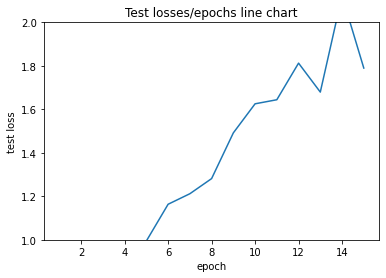

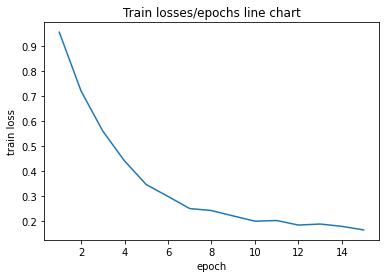

In [43]:
# draw plots
import matplotlib.pyplot as plt
epochs = range(1, 16) # 1~15 epochs
test_losses = _losses  
plt.plot(epochs, test_losses)
plt.title('Test losses/epochs line chart') 
plt.xlabel('epoch')
plt.ylabel('test loss')
plt.ylim([1, 2]) # Cross Entropy: summation [log(-(機率)＊布林值)]
plt.show()
##########
epochs = range(1, 16) # 1~15 epochs
train_losses = train_losses  
plt.plot(epochs, train_losses)
plt.title('Train losses/epochs line chart') 
plt.xlabel('epoch')
plt.ylabel('train loss')
# plt.ylim([1, 2]) # Cross Entropy: summation [log(-(機率)＊布林值)]
plt.show()